# Comparing Common Crawl's Domain-Level Harmonic Centrality Ranks



A comparison of top web sites rankings

- the list of [top-1-million sites](http://s3.amazonaws.com/alexa-static/top-1m.csv.zip) published by [Alexa](https://support.alexa.com/hc/en-us/sections/200063274-Top-Sites), based on unique visitors and page views
- the [Cisco Umbrella Popularity list](http://s3-us-west-1.amazonaws.com/umbrella-static/index.html) which reflects DNS usage
- the [Majestic Million](http://downloads.majestic.com/majestic_million.csv), "[ordered by the number of referring subnets](https://blog.majestic.com/development/majestic-million-csv-daily/)"
- the [Tranco list](https://tranco-list.eu/)
- the top million domains ranked by harmonic centrality from [Common Crawls Jun/Jul/Sep 2021 webgraph dataset](https://commoncrawl.org/2021/10/host-and-domain-level-web-graphs-jun-jul-sep-2021/)

The work is largely inspired by the [Tranco research paper](https://tranco-list.eu/assets/tranco-ndss19.pdf) by Victor Le Pochat, Tom Van Goethem, Samaneh Tajalizadehkhoob, Maciej Korczyński and Wouter Joosen.

Caveats: the lists differ in their
- notion of a web site (a host, a subdomain, a registered domain)
- methodology to rank sites
  - Alexa: traffic / visitors
  - Cisco Umbrella: DNS traffic
  - Majestic: backlinks aggregated by IPv4 /24 subnets
  - Tranco: weighted combination of the above (plus Quantcast)
  - Common Crawl: harmonic centrality
- data aggregation time: while the others provide daily updates, Common Crawl releases domain rankings 3-4 times per year



## List Download and Read Data

A shell script to download all lists (executed on Oct 09, 2021):
```bash
#!/bin/bash

dir="ranks-2021-10-09"

mkdir -p "$dir"

curl "http://s3.amazonaws.com/alexa-static/top-1m.csv.zip" | gzip -dc >"$dir"/alexa.csv
curl "http://downloads.majestic.com/majestic_million.csv" >"$dir"/majestic.csv
curl "http://s3-us-west-1.amazonaws.com/umbrella-static/top-1m.csv.zip" | gzip -dc >"$dir"/umbrella.csv

# find latest Tranco list
curr_tranco_link=$(lynx -dump "https://tranco-list.eu/latest_list" \
                    | grep -Eo 'https://tranco-list.eu/download/[^/]+/1000000')
curr_tranco_id=$(echo $curr_tranco_link | cut -d/ -f5 | tr -d '\n')
curl $curr_tranco_link >"$dir"/tranco.csv

# take top 1M from latest Common Crawl domain-level rankings
curl https://commoncrawl.s3.amazonaws.com/projects/hyperlinkgraph/cc-main-2021-jun-jul-sep/domain/cc-main-2021-jun-jul-sep-domain-ranks.txt.gz | gzip -dc | head -1000001 >"$dir"/cc.tsv
```

In [1]:
# read the data

import os

import pandas as pd

base = 'ranks-2021-10-09'

lists = {}

lists['Alexa'] = pd.read_csv(os.path.join(base, 'alexa.csv'), header=None, names=['rank', 'domain'])
lists['Umbrella'] = pd.read_csv(os.path.join(base, 'umbrella.csv'), header=None, names=['rank', 'domain'])
lists['Tranco'] = pd.read_csv(os.path.join(base, 'tranco.csv'), header=None, names=['rank', 'domain'])

# Majestic
majestic_ = pd.read_csv(os.path.join(base, 'majestic.csv'))
majestic = pd.DataFrame()
majestic[['rank', 'domain']] = majestic_[['GlobalRank', 'Domain']]
lists['Majestic'] = majestic

# Common Crawl
def reverse_host(host):
    parts = host.split('.')
    parts.reverse()
    return '.'.join(parts)

cc = pd.read_csv(os.path.join(base, 'cc.tsv'), delimiter='\t')
cc['domain'] = cc['#host_rev'].apply(reverse_host)
cc.rename(columns={'#harmonicc_pos': 'rank'}, inplace=True)
cc.drop(columns=['#harmonicc_val', '#pr_pos', '#pr_val', '#host_rev', '#n_hosts'], inplace=True)
lists['CC'] = cc

## Top 20 Sites

In [2]:
top_df = pd.DataFrame()
for l in lists:
    top_df[l] = lists[l].head(20)['domain']

top_df

,Alexa,Umbrella,Tranco,Majestic,CC
0,google.com,google.com,google.com,google.com,googleapis.com
1,youtube.com,netflix.com,youtube.com,facebook.com,facebook.com
2,tmall.com,www.google.com,facebook.com,youtube.com,google.com
3,qq.com,microsoft.com,netflix.com,twitter.com,w.org
4,baidu.com,ftl.netflix.com,microsoft.com,instagram.com,twitter.com
5,sohu.com,prod.ftl.netflix.com,twitter.com,linkedin.com,youtube.com
6,facebook.com,api-global.netflix.com,instagram.com,microsoft.com,instagram.com
7,taobao.com,data.microsoft.com,tmall.com,apple.com,googletagmanager.com
8,360.cn,nrdp.prod.ftl.netflix.com,linkedin.com,wikipedia.org,gmpg.org
9,jd.com,ichnaea.netflix.com,apple.com,wordpress.org,linkedin.com


## Count of Top-Level Domains among the Top-1M Sites

See also [TLDS in cc-crawl-statistics](https://commoncrawl.github.io/cc-crawl-statistics/plots/tlds) which reflect the TLD coverage in web page captures

In [3]:
# count TLDs

from collections import defaultdict

tlds = defaultdict(dict)

def tld(host):
    return host.split('.')[-1]

for l in lists:
    for idx, row in lists[l]['domain'].apply(tld).value_counts().iteritems():
        tlds[l][idx] = row

tld_df = pd.DataFrame(tlds, dtype=int).fillna(0).astype(int).sort_values(['CC'], ascending=0)
tld_df.head(10)

,Alexa,Umbrella,Tranco,Majestic,CC
com,328328,593257,514751,506939,436218
org,20862,35939,71150,86922,120166
net,21267,157949,46573,43682,44364
de,2787,8413,26784,31902,40472
uk,5990,11990,20884,26158,31902
it,1280,3309,8621,9367,18965
fr,2291,3490,8429,9300,16321
nl,735,3293,10303,14737,13330
br,1269,4899,7784,6956,13159
info,3254,2006,7793,8167,12935


In [4]:
# percentage of TLD in top-million domain lists

tld_df.apply(lambda x: 100 * x / float(x.sum())).head(20)

,Alexa,Umbrella,Tranco,Majestic,CC
com,56.990604,59.3257,51.4751,50.6939,43.6218
org,3.621190,3.5939,7.1150,8.6922,12.0166
net,3.691489,15.7949,4.6573,4.3682,4.4364
de,0.483763,0.8413,2.6784,3.1902,4.0472
uk,1.039734,1.1990,2.0884,2.6158,3.1902
it,0.222180,0.3309,0.8621,0.9367,1.8965
fr,0.397668,0.3490,0.8429,0.9300,1.6321
nl,0.127580,0.3293,1.0303,1.4737,1.3330
br,0.220271,0.4899,0.7784,0.6956,1.3159
info,0.564824,0.2006,0.7793,0.8167,1.2935


In [5]:
# percentage of continents by country-code TLD

#!pip install a-world-of-countries

import awoc

from icctld import icctld2cctld

world = awoc.AWOC()
tld_continent = {}

for continent in world.get_continents_list():
    for country in world.get_countries_list_of(continent):
        tld = world.get_country_TLD(country)
        if tld:
            tld_continent[tld] = continent

for icctld in icctld2cctld:
    if icctld2cctld[icctld] in tld_continent:
        tld_continent[icctld] = tld_continent[icctld2cctld[icctld]]

continents = tld_df.reset_index()
continents['Continent'] = continents['index'].apply(
    lambda x: tld_continent[x] if x in tld_continent else '(generic etc.)')
continents.groupby(['Continent']).sum().apply(
    lambda x: 100 * x / float(x.sum())).sort_values(['CC'], ascending=0)

,Alexa,Umbrella,Tranco,Majestic,CC
Continent,,,,,
(generic etc.),70.184462,84.5638,69.0205,68.7303,64.6606
Europe,10.459479,6.3905,16.3954,18.8020,23.5802
Asia,12.761300,5.3820,8.3497,6.8734,5.1279
South America,1.780566,1.2339,2.0610,1.6045,2.3730
Oceania,1.945465,0.7940,1.5058,1.5049,1.8515
North America,1.760604,1.3711,1.7441,1.7052,1.8062
Africa,1.107950,0.2647,0.9231,0.7793,0.5990
Antarctica,0.000174,0.0000,0.0004,0.0004,0.0016


## Correlation between Ranked Lists

Rank-Biased Overlap (RBO), see
- Webber, Moffat, Zobel, 2010: [A similarity measure for indefinite rankings](http://codalism.com/research/papers/wmz10_tois.pdf)
- the [rbo](https://pypi.org/project/rbo/) Python module

In [6]:
#!pip install rbo

import rbo

corr_matrix = defaultdict(dict)

for n in lists:
    for m in lists:
        if n == m:
            corr_matrix[n][m] = corr_matrix[m][n] = 1.0
            continue
        if n > m:
            continue
        nl = lists[n]['domain'].values
        ml = lists[m]['domain'].values
        rbo_sim = rbo.RankingSimilarity(nl, ml).rbo()
        overlap = len(set(nl) & set(ml))
        union = len(set(nl) | set(ml))
        jaccard_sim = overlap / union
        print("{:.3f}\t{:6d}\t{:7d}\t{:.3f}\t{} <> {}".format(rbo_sim, overlap, union, jaccard_sim, n, m))
        corr_matrix[n][m] = corr_matrix[m][n] = rbo_sim

0.084	 78558	1497551	0.052	Alexa <> Umbrella
0.373	242107	1334002	0.181	Alexa <> Tranco
0.213	148753	1427356	0.104	Alexa <> Majestic
0.157	107870	1468239	0.073	Alexa <> CC
0.172	180240	1819760	0.099	Tranco <> Umbrella
0.092	109079	1890921	0.058	Majestic <> Umbrella
0.730	774468	1225532	0.632	Majestic <> Tranco
0.075	 84299	1915701	0.044	CC <> Umbrella
0.322	332378	1667622	0.199	CC <> Tranco
0.346	369448	1630552	0.227	CC <> Majestic


In [7]:
corr = pd.DataFrame(corr_matrix)
corr

,Alexa,Umbrella,Tranco,Majestic,CC
Alexa,1.000000,0.084150,0.373255,0.213281,0.157222
Umbrella,0.084150,1.000000,0.171853,0.092091,0.074710
Tranco,0.373255,0.171853,1.000000,0.730000,0.321721
Majestic,0.213281,0.092091,0.730000,1.000000,0.345904
CC,0.157222,0.074710,0.321721,0.345904,1.000000


<AxesSubplot:>

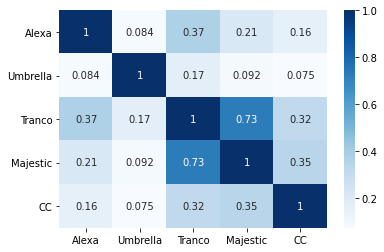

In [8]:
import matplotlib.pyplot as plt
import seaborn as sb

corr_heatmap = sb.heatmap(corr, cmap="Blues", annot=True)
plt.savefig('corr_ranks_rbo.svg')
corr_heatmap